In [2]:
##IMPORT
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import colorsys
from torch import nn

In [9]:
class PINN_multi(nn.Module):
    def __init__(
        self,
        t,
        v,
        I,
        layers_struc,
        lb,
        ub,
        max_iter_lbfgs=50000,
        line_sh="strong_wolfe",
        Ek=-96.2,
        gk=0.1,
        device="cpu",
    ):

        super(PINN_multi, self).__init__()

        # device
        self.dev = device

        # bounds
        self.lb = torch.tensor(lb, device=self.dev)
        self.ub = torch.tensor(ub, device=self.dev)
        # ion channel
        self.Ek = torch.tensor(Ek, device=self.dev)
        self.gk = torch.tensor(gk, device=self.dev)

        # data
        self.v = torch.tensor(
            v, dtype=torch.float64, requires_grad=True, device=self.dev
        ).unsqueeze(-1)
        self.t = torch.tensor(
            t, dtype=torch.float64, requires_grad=True, device=self.dev
        ).unsqueeze(-1)
        self.I = torch.tensor(
            I, dtype=torch.float64, requires_grad=True, device=self.dev
        )

        # Build data structure
        self.t_rep, self.v_rep, self.input = self.construct_input(self.t, self.v)

        # layer structure
        self.layers_struc = layers_struc

        # Build neural nets
        last_layer = nn.Linear(layers_struc[-2], 1)
        layers = [
            nn.Sequential(nn.Linear(input_, output_), nn.Tanh()).double()
            for input_, output_ in zip(layers_struc[:-1], layers_struc[1:-1])
        ] + [last_layer]

        self.net_i = nn.Sequential(*layers).double().to(self.dev)

        last_layer = nn.Linear(layers_struc[-2], 1)
        layers = [
            nn.Sequential(nn.Linear(input_, output_), nn.Tanh())
            for input_, output_ in zip(layers_struc[:-1], layers_struc[1:-1])
        ] + [last_layer]

        self.net_m = nn.Sequential(*layers).double().to(self.dev)

        last_layer = nn.Linear(layers_struc[-2], 1)
        layers = [
            nn.Sequential(nn.Linear(input_, output_), nn.Tanh())
            for input_, output_ in zip(layers_struc[:-1], layers_struc[1:-1])
        ] + [last_layer]

        self.net_h = nn.Sequential(*layers).double().to(self.dev)

        # Initialize parameters
        tensor = torch.ones((2,), dtype=torch.float64)
        m_tau = tensor.new_tensor(np.full(len(v), 1.0), device=self.dev)
        m_inf = tensor.new_tensor(np.full(len(v), 1.0), device=self.dev)
        h_tau = tensor.new_tensor(np.full(len(v), 1.0), device=self.dev)
        h_inf = tensor.new_tensor(np.full(len(v), 0.0), device=self.dev)

        self.m_tau = torch.nn.Parameter(m_tau)
        self.h_tau = torch.nn.Parameter(h_tau)
        self.m_inf = torch.nn.Parameter(m_inf)
        self.h_inf = torch.nn.Parameter(h_inf)

        # optimizer
        self.optimizer = torch.optim.LBFGS(
            self.parameters(),
            max_iter=max_iter_lbfgs,
            tolerance_grad=1.0 * np.finfo(float).eps,
            line_search_fn=line_sh,
        )

        self.adam_optimizer = torch.optim.Adam(self.parameters())

        # Histories for debugging
        self.lossHist = []
        self.f1LossHist = []
        self.f2LossHist = []
        self.f3LossHist = []
        self.f4LossHist = []
        self.f5LossHist = []
        self.iLossHist = []

    def construct_input(self, t, v):
        """construct input structure from time and voltage data. t and v have to be torch tensors"""

        # normalize input
        # t = 2.0 * (t - self.lb[0]) / (self.ub[0] - self.lb[0]) - 1.0
        # v = 2.0 * (v - self.lb[1]) / (self.ub[1] - self.lb[1]) - 1.0

        t_rep = torch.tile(t, (1, len(v))).transpose(0, 1)  # replicate t vector
        v_rep = torch.tile(v, (1, len(t)))  # replicate v vector

        t_n = 2.0 * (t_rep - self.lb[0]) / (self.ub[0] - self.lb[0]) - 1.0
        v_n = 2.0 * (v_rep - self.lb[1]) / (self.ub[1] - self.lb[1]) - 1.0

        input = torch.stack((t_n, v_n)).transpose(0, 2)  # 2D input

        return t_rep, v_rep, input

    def nets(self, input):
        """Forward pass into the 3 neural nets"""

        I = self.net_i(input)
        m = self.net_m(input)
        h = self.net_h(input)

        return I, m, h

    def net_f(self, input):
        """computes the ODEs and functions to be used in the loss"""

        # forward pass
        I, m, h = self.nets(input)

        # f1
        f1 = self.normalize_i(self.gk * m * m * h * (self.v - self.Ek)) - I

        # f2-f3
        m = m.squeeze()
        h = h.squeeze()
        # derivative
        m_t = torch.autograd.grad(
            m,
            self.t_rep,
            grad_outputs=torch.ones(
                len(h), len(self.v), device=self.dev, dtype=torch.float64
            ).squeeze(),
            retain_graph=True,
            only_inputs=True,
            create_graph=True,
        )[0]

        h_t = torch.autograd.grad(
            h,
            self.t_rep,
            grad_outputs=torch.ones(
                len(h), len(self.v), dtype=torch.float64, device=self.dev
            ).squeeze(),
            retain_graph=True,
            only_inputs=True,
            create_graph=True,
        )[0]

        f2 = 50 * (
            (self.m_inf.unsqueeze(-1) - m.transpose(0, 1))
            / (self.m_tau.unsqueeze(-1) * 50)
            - m_t
        )
        f3 = 500 * (
            (self.h_inf.unsqueeze(-1) - h.transpose(0, 1))
            / (self.h_tau.unsqueeze(-1) * 500)
            - h_t
        )

        # f4-f5

        _, _, input0 = self.construct_input(
            torch.tensor([0], dtype=torch.float64, device=self.dev), self.v
        )
        _, m0, h0 = self.nets(input0)

        f4 = m0
        f5 = h0 - torch.tensor([1], dtype=torch.float64, device=self.dev)

        return f1, f2, f3, f4, f5, I

    def loss_fn(self, f1, f2, f3, f4, f5, Ik_out, target):
        loss = nn.MSELoss()

        MSE_i = loss(torch.squeeze(Ik_out), torch.squeeze(self.normalize_i(target)))
        MSE_f1 = loss(f1, torch.zeros(f1.shape, dtype=torch.float64, device=self.dev))
        MSE_f2 = loss(f2, torch.zeros(f2.shape, dtype=torch.float64, device=self.dev))
        MSE_f3 = loss(f3, torch.zeros(f3.shape, dtype=torch.float64, device=self.dev))
        MSE_f4 = loss(f4, torch.zeros(f4.shape, dtype=torch.float64, device=self.dev))
        MSE_f5 = loss(f5, torch.zeros(f5.shape, dtype=torch.float64, device=self.dev))

        # store Losses
        self.iLossHist.append(MSE_i.item())
        self.f1LossHist.append(MSE_f1.item())
        self.f2LossHist.append(MSE_f2.item())
        self.f3LossHist.append(MSE_f3.item())

        return MSE_i + MSE_f1 + 10 * MSE_f2 + 10 * MSE_f3 + MSE_f4 + MSE_f5

    def normalize_i(self, inp):
        inp_n = 2.0 * (inp - self.I.min()) / (self.I.max() - self.I.min()) - 1.0
        return inp_n

    def train_adam(self, iterations):
        """train using ADAM optimizer"""

        for it in range(iterations):

            # forward pass
            f1, f2, f3, f4, f5, i_est = self.net_f(self.input)
            loss = self.loss_fn(f1, f2, f3, f4, f5, i_est, self.I)

            # backward pass
            loss.backward(retain_graph=True)
            self.adam_optimizer.step()

            self.adam_optimizer.zero_grad()  # reset gradients

            # display losses
            if (it % 10) == 0:
                print("It: %d, Loss: %.3e" % (it, loss.item()))
                # Store parameters history
                self.lossHist.append(loss.item())

    def train_lbfgs(self):
        """Function for lbfgs optimizer"""

        def closure():

            # reset gradients
            self.optimizer.zero_grad()
            if self.I.grad is not None:
                self.I.grad.zero_()

            # forward pass
            f1, f2, f3, f4, f5, i_est = self.net_f(self.input)
            loss = self.loss_fn(f1, f2, f3, f4, f5, i_est, self.I)

            # backward pass
            if loss.requires_grad:
                loss.backward(retain_graph=True)

            print("Loss: %.3e" % loss.item())

            # Store parameters history
            self.lossHist.append(loss.item())

            return loss

        self.optimizer.step(closure)

    def train(self, adam_it):
        self.train_adam(adam_it)
        self.train_lbfgs()
        print("training over")

    def predict(self, Xin):
        """feed-forward pass into the model. Xin has to be a stacked 3D tensor (as built in self._init_)"""
        i, _, _ = self.nets(Xin)

        return i.cpu().detach().numpy()

In [10]:
#####PARAMETERS#####
#plotting
PLOT = 1

#Optimizer
MAX_ITER_LBFGS = 50000
LINESEARCH = "strong_wolfe" #"strong_wolfe" or None

#ION Channel properties
E_K = torch.tensor([-96.2], dtype = torch.float64)
G_K = torch.tensor([0.1], dtype = torch.float64)

#Model
NN_DEPTH = 15
NN_BREADTH = 20

#Training
ADAM_IT = 10000
WHOLE_DATA = False
DEVICE = "cpu"
LINE_SH = "strong_wolfe"

if not WHOLE_DATA:
    N_T = 2000 #Training set size

In [11]:
###TRAINING DATA

#Build layer list
layers = [2] #nb of inputs
for i in range(NN_DEPTH):  # nb of layers
    layers.append(NN_BREADTH)
layers.append(1) #output size

#import  data
PATH = 'Kv1.2_2505_rep2_Current.txt'
data = pd.read_csv(PATH, header=None, delim_whitespace=True)
t = data[0].to_numpy()
Ik = data.iloc[:, 1:]


PATH_act = 'Kv1.2_2505_rep2_Stimulus.txt'
v_act = pd.read_csv(PATH_act, header=None, delim_whitespace=True).to_numpy().squeeze()
v_train = v_act


# Domain bounds
lb = np.asarray([t.min(0), v_act.min(-1)])
ub = np.asarray([t.max(0), v_act.max(-1)])

<ipython-input-11-bd7ee2b6c6c9>:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(PATH, header=None, delim_whitespace=True)
<ipython-input-11-bd7ee2b6c6c9>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  v_act = pd.read_csv(PATH_act, header=None, delim_whitespace=True).to_numpy().squeeze()


In [13]:
import numpy as np
import torch


def xavier_init_routine(m):
    """function for weight initialization"""
    if type(m) == torch.nn.Linear:

        # manual xavier initialization
        xavier_stddev = np.sqrt(2 / (m.in_features + m.out_features))
        torch.nn.init.trunc_normal_(m.weight, mean=0, std=xavier_stddev)
        # torch.nn.init.xavier_normal_(m.weight, gain=1)

        m.bias.data.fill_(0)


def weighted_mse_loss(input, target):
    weights = np.ones(len(input))
    weights[0:10] = 10
    weights = torch.tensor(weights, dtype=torch.float64)

    return torch.sum(weights * (input - target) ** 2)

In [14]:
############ TRAINING #############

if WHOLE_DATA:
    # use all the data
    t_train = t
    Ik_df = Ik

else:
    idx = np.arange(11)  # make sure rise is in training data
    idx = np.sort(np.concatenate((idx, np.random.choice(t.shape[0], N_T, replace=False))))
    t_train = t[idx]
    Ik_df = Ik.iloc[idx, :]

# Build model
model = PINN_multi(t_train, v_train, Ik_df.to_numpy(), layers, lb, ub, line_sh = LINE_SH, max_iter_lbfgs=MAX_ITER_LBFGS, device = DEVICE)
model.apply(xavier_init_routine)  # initialize nn

# TRAIN
model.train(ADAM_IT)

Streaming output truncated to the last 5000 lines.
Loss: 1.628e-03
Loss: 1.629e-03
Loss: 1.628e-03
Loss: 1.628e-03
Loss: 1.629e-03
Loss: 1.628e-03
Loss: 1.628e-03
Loss: 1.628e-03
Loss: 1.628e-03
Loss: 1.628e-03
Loss: 1.628e-03
Loss: 1.628e-03
Loss: 1.628e-03
Loss: 1.628e-03
Loss: 1.627e-03
Loss: 1.627e-03
Loss: 1.627e-03
Loss: 1.627e-03
Loss: 1.627e-03
Loss: 1.627e-03
Loss: 1.627e-03
Loss: 1.626e-03
Loss: 1.626e-03
Loss: 1.626e-03
Loss: 1.626e-03
Loss: 1.626e-03
Loss: 1.626e-03
Loss: 1.626e-03
Loss: 1.626e-03
Loss: 1.626e-03
Loss: 1.626e-03
Loss: 1.625e-03
Loss: 1.625e-03
Loss: 1.625e-03
Loss: 1.625e-03
Loss: 1.625e-03
Loss: 1.625e-03
Loss: 1.624e-03
Loss: 1.624e-03
Loss: 1.628e-03
Loss: 1.624e-03
Loss: 1.624e-03
Loss: 1.624e-03
Loss: 1.624e-03
Loss: 1.623e-03
Loss: 1.623e-03
Loss: 1.623e-03
Loss: 1.623e-03
Loss: 1.623e-03
Loss: 1.622e-03
Loss: 1.622e-03
Loss: 1.622e-03
Loss: 1.622e-03
Loss: 1.622e-03
Loss: 1.724e-03
Loss: 1.621e-03
Loss: 1.621e-03
Loss: 1.621e-03
Loss: 1.621e-03
Loss:

KeyboardInterrupt: 

In [15]:
# Save model after interrupt
torch.save(model.state_dict(), "PINN_model_final.pth")


In [16]:
#utility fucntion for plotting
def lighten_color(color, amount=0.5):
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

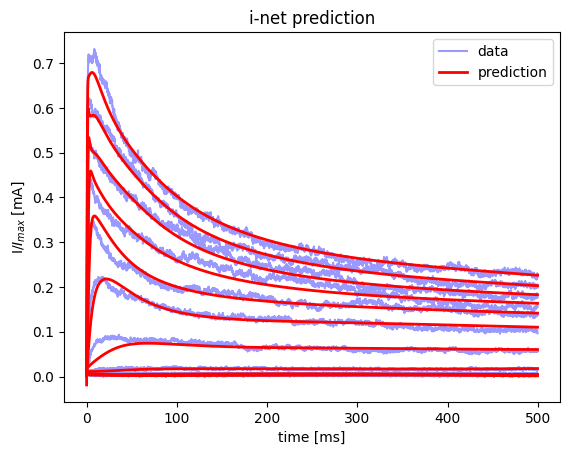

In [19]:
#PREDICTIONS

#CONSTRUCT INPUT DATA for prediction
t_tens = torch.tensor(t, dtype=torch.float64, device = "cpu").unsqueeze(-1)
v_tens = torch.tensor(v_train, dtype=torch.float64, device = "cpu").unsqueeze(-1)
_, _, Xin = model.construct_input(t_tens, v_tens)

u_pred = model.predict(Xin)
u_pred = ((u_pred + 1)*(model.I.max().cpu().detach().numpy() - model.I.min().cpu().detach().numpy())/2+model.I.min().cpu().detach().numpy())



plt.title("i-net prediction")
plt.xlabel("time [ms]")
plt.ylabel(r"I/$I_{max}$ [mA]")
plt.plot(t, Ik.to_numpy()[:, :-1], color=lighten_color('b', 0.4))
plt.plot(t, Ik.to_numpy()[:, -1], label = "data", color=lighten_color('b', 0.4))

plt.plot(t, np.squeeze(u_pred)[:, :-1], 'r', linewidth = 2.0)
plt.plot(t, np.squeeze(u_pred)[:, -1], 'r', label = "prediction", linewidth = 2.0)
plt.legend()

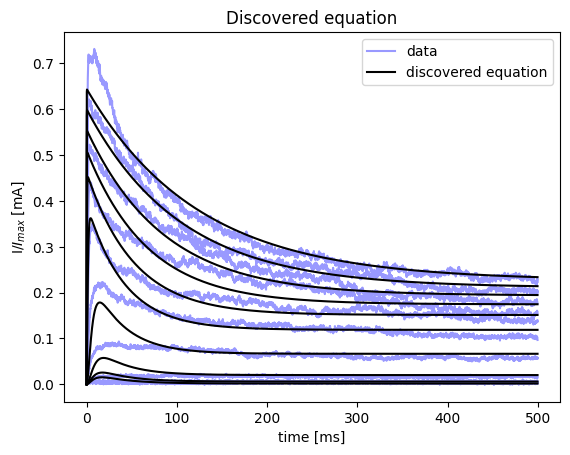

In [21]:
from scipy.integrate import odeint
def func(p, t, p_inf, p_tau):
    dp = (p_inf - p) / p_tau
    return dp

#Ik = Ik.to_numpy()
m_reg = odeint(func, np.zeros(10), t, args = (model.m_inf.cpu().detach().numpy(), model.m_tau.cpu().detach().numpy()*5))
h_reg = odeint(func, np.ones(10), t, args = (model.h_inf.cpu().detach().numpy(), model.h_tau.cpu().detach().numpy()*500))
I_reg =  0.1*m_reg*m_reg*h_reg*(v_act - (-96.2))


plt.title("Discovered equation")
plt.plot(t, Ik.to_numpy()[:, :-1], color=lighten_color('b', 0.4))
plt.plot(t, Ik.to_numpy()[:, -1], label = "data",color=lighten_color('b', 0.4))
plt.plot(t, I_reg[:, :-1], 'k')
plt.plot(t, I_reg[:, -1], 'k', label = "discovered equation")

plt.xlabel("time [ms]")
plt.ylabel(r"I/$I_{max}$ [mA]")
plt.legend()


In [22]:
loss = nn.MSELoss()
netMSE = loss(torch.Tensor(np.squeeze(u_pred)), torch.Tensor(Ik.to_numpy()))
print('%.10f' %netMSE)

0.0000855110


In [23]:
eqMSE = loss(torch.Tensor(I_reg.squeeze()), torch.Tensor(Ik.to_numpy().squeeze()))
print('%.10f' %eqMSE)

0.0005145116
